# Measurement Error Mitigation - Calibration Matrix

We are going to start with a brief explanation of how General Measurement Error Mitigation (MEM) can be implemented and then its implementation on the Standard Quantum Teleportation protocol.

In [1]:
# Needed packages importing
import numpy as np
from numpy import *
import cvxpy as cp
import matplotlib.pyplot as plt
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer, transpile, assemble, Aer, IBMQ 
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.extensions import Initialize
from qiskit.tools import job_monitor

In [2]:
# Loading your IBM Quantum account(s)
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
simulator = Aer.get_backend('qasm_simulator')
backend = provider.get_backend('ibmq_manila')
simulator = Aer.get_backend('qasm_simulator')
backendsv = BasicAer.get_backend('statevector_simulator')

In order to exemplify it in an easier way the implementation, we are going to say first that we wish to provide MEM of a circuit based on a single qubit and the application of the H-gate on it. So, we are going to construct the corresponding Calibration matrix.

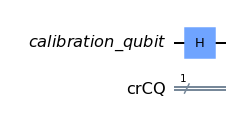

In [3]:
# This basic Circuit
single_qubit = QuantumRegister(1, 'calibration_qubit')
single_bit = ClassicalRegister(1, 'crCQ')
mycircuit = QuantumCircuit(single_qubit, single_bit)
mycircuit.h(0)
mycircuit.draw('mpl')

We are going to use the Unitary condition that it possesses. Then, we need to construct two circuits, where the basic idea is: we prepare the qubit in the quantum state 0. We proceed to measure this qubit in an experiment of 1000 shots. If the device is completely accurate, then we should get an answer of 1000 times the quantum state 0. In state-of-art quantum devices, there are prone-error, and this is what we are going to try to improve. The second circuit will have the qubit initialized in the quantum state 1, and again it is measured. Then, we proceed to construct the calibration matrix, where we say that the times that the quantum state was measured in a state in which it was not prepared is an error caused by the measurement of it.

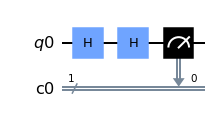

In [4]:
# First Circuit
qr = QuantumRegister(1)
cr = ClassicalRegister(1)
cal_cir = QuantumCircuit(qr, cr)
cal_cir.h(0)
cal_cir.h(0)
cal_cir.measure(0,0)
cal_cir.draw('mpl')

In [5]:
nshots = 10_000
counts = execute(cal_cir, backend = simulator, shots = nshots).result().get_counts()

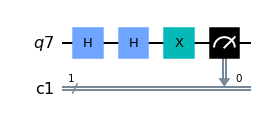

In [6]:
# Second Circuit
sqr = QuantumRegister(1)
scr = ClassicalRegister(1)
scal_cir = QuantumCircuit(sqr, scr)
scal_cir.h(0)
scal_cir.h(0)
scal_cir.x(0)
scal_cir.measure(0,0)
scal_cir.draw('mpl')

In [7]:
nshots = 10_000
scounts = execute(scal_cir, backend = simulator, shots = nshots).result().get_counts()

Now, we can introduce the values on the calibration matrix, taking the counts of each circuit.

In [8]:
# Reading Data
for i in range(2):
    for k,v in counts.items():
        ans = [k[::-1],v]
    for sk,sv in scounts.items():
        sans = [sk[::-1],sv]
# Calibration Matrix
cal_matrix = zeros((2,2))
cal_matrix[0,0] = ans[1]/nshots
cal_matrix[1,1] = sans[1]/nshots
array_to_latex(cal_matrix)

<IPython.core.display.Latex object>

For this case, the calibration matrix is easy given that we are dealing with simulations without noise, and additionally the depth of the circuit is small. On the other hand, the computation of the calibration matrix will be more complex when we need to increase the amount of qubits to be calibrated and the number of quantum gates.

# Calibration Matrix for the Standard Quantum Teleportation Protocol

We can check in Quantum Teleportation repository, all needed steps to accomplish the Standard Quantum Teleportation. To use MEM techniques into it, we are going to get the following quantum circuits:

In [9]:
# Generation of a single gate of the SQT circuit
cal_circuit = QuantumCircuit(3)
cal_circuit.h(1)
cal_circuit.cx(1,2)
cal_circuit.cx(0,1)
cal_circuit.h(0)
cal_circuit.cz(0,2)
cal_circuit.cx(1,2)
#Reversal
cal_circuit.cx(1,2)
cal_circuit.cz(0,2)
cal_circuit.h(0)
cal_circuit.cx(0,1)
cal_circuit.cx(1,2)
cal_circuit.h(1)
#To gate
sqt_gate = cal_circuit.to_gate()

In [13]:
# The SQT Circuit
n_qubits = 3
cal_matrix = zeros((2**n_qubits, 2**n_qubits))

for i in range(2**n_qubits):
    sqt_qr = QuantumRegister(n_qubits)
    sqt_cr = ClassicalRegister(3)
    sqt_cir = QuantumCircuit(sqt_qr, sqt_cr)
    sqt_cir.append(sqt_gate,[0,1,2])
    sqt_cir.barrier()
    #For MEM
    if i==1:
        sqt_cir.x(0)
        sqt_cir.barrier()
    if i==2:
        sqt_cir.x(1)
        sqt_cir.barrier()
    if i==3:
        sqt_cir.x(0)
        sqt_cir.x(1)
        sqt_cir.barrier()
    if i==4:
        sqt_cir.x(2)
        sqt_cir.barrier()
    if i==5:
        sqt_cir.x(1)
        sqt_cir.x(2)
        sqt_cir.barrier()
    if i==6:
        sqt_cir.x(1)
        sqt_cir.x(2)
        sqt_cir.barrier()
    if i==7:
        sqt_cir.x(0)
        sqt_cir.x(1)
        sqt_cir.x(2)
        sqt_cir.barrier()
    #Measurements
    sqt_cir.measure([0,1,2],[0,1,2])
    #Executions
    nshots = 10_000
    counts = execute(sqt_cir, backend = simulator, shots = nshots).result().get_counts()
    #Data_reading
    cal_data = [(k[::-1],v) for k,v in counts.items()]
    cal_data.sort(key = lambda x: x[1], reverse=True)
    cal_imp = []
    for k, v in cal_data: cal_imp.append( [ int(c) for c in k ] )
    #Filling the calibration matrix
    for l in range(len(cal_imp)):
        num_dec = 0
        for j in range(n_qubits):
            num_dec += (2**j)*(cal_imp[l][j])
        cal_matrix[num_dec,i] = cal_data[l][1]/nshots
array_to_latex(cal_matrix)

<IPython.core.display.Latex object>

Now, the calibration matrix can be experimentally obtained by choosing a real device. It is important to remember that once the calibration procedure is applied, we need need to check that our data correctly accomplish the probability density distribution, given that using particular software to solve the linear system used to give back the corrected data could compute negative entries, which can be controlled by setting the correct restrictions on how we wish to solve the linear system. 